#Sentiment Analysis with an RNN

Analysis also recognizes that the study of ideas refers to the identification, extraction and study of emotional states through natural language processing, textual analysis, computer languages ​​and biometrics.

### Imports

In [1]:
import os

# Time
import time
import datetime

# Numerical
import numpy as np
import pandas as pd

# Tools
import itertools
from collections import Counter

# NLP
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Preprocessing
import string
from sklearn import svm
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MultiLabelBinarizer
#from sklearn.model_selection import *
from sklearn.linear_model import SGDClassifier, LogisticRegression
#from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

# Model Selection
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learing Preprocessing - Keras
import keras
from tensorflow import keras
from tensorflow.keras import layers
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Deep Learning Model - Keras
from keras.models import Model, Sequential, load_model
#from keras.models import Sequential, load_model

# Deep Learning Model - Keras - RNN
from keras.layers import LSTM, Embedding, Bidirectional
#from keras.layers import Dense, Embedding

# Deep Learning Model - Keras - General
from keras.initializers import Constant
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten, GlobalMaxPooling1D, Conv1D
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply

from keras.preprocessing import sequence
from keras import regularizers

# Multi-layer Perceptron classifier (MLP)
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
#from time import time
from sklearn.neural_network import MLPClassifier
import logging

# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.imports import *
from fastai.text import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
path = Path(os.path.abspath(os.curdir))

### Loading in Dataset

In [3]:
traindata = pd.DataFrame
traindata = pd.read_csv('/content/iclr2021_reviews_train.csv')
testdata = pd.read_csv('/content/iclr2021_reviews_test.csv')
traindata = traindata.sample(frac=1).reset_index(drop=True)
print(traindata.shape)
traindata.head()

(2534, 4)


,review,decision,sentiments,labels
0,\nSummary: This paper leverages an explicit pr...,Reject,Neutral,Reject
1,The paper presents three techniques to train a...,Accept,Positive,Accept (Poster)
2,The paper proposed a novel regularizer that is...,Accept,Positive,Accept (Poster)
3,The authors show that two types of singulariti...,Accept,Positive,Accept (Poster)
4,The paper proposes a method for adapting a pre...,Reject,Negative,Reject


### Removing all columns except the sentiments and review column.

In [4]:
data = traindata[['sentiments','review']]
data.head()

,sentiments,review
0,Neutral,\nSummary: This paper leverages an explicit pr...
1,Positive,The paper presents three techniques to train a...
2,Positive,The paper proposed a novel regularizer that is...
3,Positive,The authors show that two types of singulariti...
4,Negative,The paper proposes a method for adapting a pre...


In [5]:
X_train = data['review'].values
y_train = data['sentiments'].values
X_test = data['review'].values
y_test = data['sentiments'].values

### Data exploration

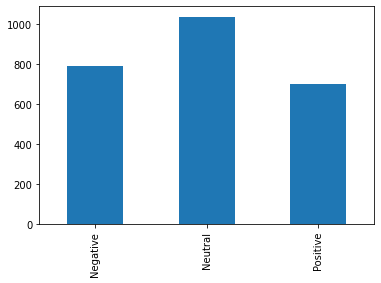

In [6]:
data['sentiments'].value_counts().sort_index().plot.bar()

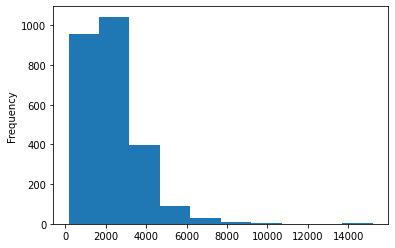

In [7]:
data['review'].str.len().plot.hist()

### Preprocessing

In [8]:
data['review'] = data['review'].str.replace('SUMMARY', '')
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sentiments,review
0,Neutral,\nSummary: This paper leverages an explicit pr...
1,Positive,The paper presents three techniques to train a...
2,Positive,The paper proposed a novel regularizer that is...
3,Positive,The authors show that two types of singulariti...
4,Negative,The paper proposes a method for adapting a pre...


### Defining cleaning method includes punctuation marks, stop words & digits

In [9]:
#Text Pre-processing
# def text_cleaning(tweet):
#     letters = re.sub("[^a-zA-Z]"," ",tweet)
#     ht = re.sub(r'http\S+', '',letters)
#     mention = re.sub(r'@\w+', '', ht)
#     p = re.sub(r'[^\w\s]','',mention)
#     words = p.lower().split()
#     stops = set(stopwords.words("english"))
#     meaningful_words = [w for w in words if not w in stops]
#     return( " ".join(meaningful_words))
# data['text_clean']=data['review'].apply(lambda x: text_cleaning(x))

In [10]:
corpus = []
for i in range(0,2534):
  review = re.sub('^a-zA-Z', ' ',data['review'][i])
  review = re.sub(r"what's", "what is ", data['review'][i])
  review = re.sub(r"\'s", " ", data['review'][i])
  review = re.sub(r"\'ve", " have ", data['review'][i])
  review = re.sub(r"can't", "cannot ", data['review'][i])
  review = re.sub(r"n't", " not ", data['review'][i])
  review = re.sub(r"i'm", "i am ", data['review'][i])
  review = re.sub(r"\'re", " are ", data['review'][i])
  review = re.sub(r"\'d", " would ", data['review'][i])
  review = re.sub(r"\'ll", " will ", data['review'][i])
  review = re.sub(r",", " ", data['review'][i])
  review = re.sub(r"\.", " ", data['review'][i])
  review = re.sub(r"!", " ! ", data['review'][i])
  review = re.sub(r"\/", " ", data['review'][i])
  review = re.sub(r"\^", " ^ ", data['review'][i])
  review = re.sub(r"\+", " + ", data['review'][i])
  review = re.sub(r"\-", " - ", data['review'][i])
  review = re.sub(r"\=", " = ", data['review'][i])
  review = re.sub(r"'", " ", data['review'][i])
  review = re.sub(r"(\d+)(k)", r"\g<1>000", data['review'][i])
  review = re.sub(r":", " : ", data['review'][i])
  review = re.sub(r" e g ", " eg ", data['review'][i])
  review = re.sub(r" b g ", " bg ", data['review'][i])
  review = re.sub(r" u s ", " american ", data['review'][i])
  review = re.sub(r"\0s", "0", data['review'][i])
  review = re.sub(r" 9 11 ", "911", data['review'][i])
  review = re.sub(r"e - mail", "email", data['review'][i])
  review = re.sub(r"j k", "jk", data['review'][i])
  review = re.sub(r"\s{2,}", " ", data['review'][i])
  review = review.lower().replace('\n\n', '').replace('_','')
  review = review.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  review = ' '.join(review)

In [11]:
#TFIDF Vectorizer, just like before
stopset = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)

In [12]:
review

'manuscript mainli present cheap prune algorithm dens layer dnns. propos algorithm improv net-trim (aghasi et al., 2016), enforc weight sparse. main contribut manuscript non-convex optim problem (aghasi et al., 2016) reformul differ convex (dc) problem, solv quit effici use dca algorithm (tao an, 1997). complex propos algorithm much lower net-trim fast version lob (dong et al., 2017). author also analyz gener error bound dnn prune base work (sokol et al., 2017). although increment work built upon (aghasi et al., 2016) exist algorithm (tao an, 1997) adopt optimization, contribut valuabl sinc complex significantli reduc util propos differ convex reformulation. although main idea clearli presented, mani syntax error suggest author care check manuscript. pros: 1. motiv clear present reformul reasonable. 2. gener error analysi conclus “layer closer input exponenti less robust pruning” interesting. cons: 1. mani syntax errors, e.g., “closer approach recent aghasi et al. (2016) authors”, “an 

### Transform text to lowercase

In [99]:
data['review'].apply(lambda x: x.lower()) #transform text to lowercase
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['review'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    \nSummary This paper leverages an explicit pro...
1    The paper presents three techniques to train a...
2    The paper proposed a novel regularizer that is...
3    The authors show that two types of singulariti...
4    The paper proposes a method for adapting a pre...
Name: review, dtype: object

### Text tokenizer in the same length

In [87]:
MAX_NUM_WORDS = 40000
MAX_SEQUENCE_LENGTH = 100

In [88]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(MAX_NUM_WORDS, split=" ")
tokenizer.fit_on_texts(data['review'].values)

X = tokenizer.texts_to_sequences(data['review'].values)
X = pad_sequences(X, MAX_SEQUENCE_LENGTH) # padding our text vector so they all have the same length
X[:10]

array([[13264,  1489,    17,    82, ...,   564,  7380,  3051,   482],
       [   32,   347,    14,  4626, ...,    48,     1,    32,   347],
       [ 5193,  1333,   106,     7, ...,     5,   334,   341,   358],
       [    1, 13276,     2,    74, ...,   918,     3,   338,    87],
       ...,
       [   20,   397,    11,     4, ...,     8,    30,    28,   984],
       [   30,    16,     1,   120, ...,  4222,   121,     1,  6619],
       [    8,    14,    15,  1825, ...,   186,  1052,     6,    67],
       [  463,  3586,    18,     1, ...,  1826,     7,     1,   356]], dtype=int32)

In [89]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

24797


In [90]:
y = pd.get_dummies(data['sentiments']).values
[print(data['sentiments'][i], y[i]) for i in range(0,10)]

# Y = data['sentiments']
# lenc = LabelEncoder()
# Y = lenc.fit_transform(Y)
# Y = to_categorical(Y)
# Y

Neutral [0 1 0]
Positive [0 0 1]
Positive [0 0 1]
Positive [0 0 1]
Negative [1 0 0]
Positive [0 0 1]
Positive [0 0 1]
Negative [1 0 0]
Neutral [0 1 0]
Positive [0 0 1]


[None, None, None, None, None, None, None, None, None, None]

### Vectorizing the data


In [18]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(traindata['review'])
test_vectors = vectorizer.transform(testdata['review'])

### Train Test Split

In [93]:
#X=data
test_size, val_size = 0.2, 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X train: {}, Y train: {}'.format(X_train.shape, y_train.shape))
print('X test: {}, Y test: {}'.format(X_test.shape, y_test.shape))

# train_x=X_train
# test_x=X_test
# train_y=y_train
# test_y=y_test

X train: (1773, 100), Y train: (1773, 3)
X test: (761, 100), Y test: (761, 3)


In [94]:
print("X train shape ",X_train.shape)
print("X test shape ",X_test.shape)
print("y train shape ",y_train.shape)
print("y test shape ",y_test.shape)

X train shape  (1773, 100)
X test shape  (761, 100)
y train shape  (1773, 3)
y test shape  (761, 3)


### Creating a Linear SVM Model

In [21]:
import time
from sklearn import svm
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, data['sentiments'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

#### Results

In [22]:
# results
print("Results for SVC(kernel=linear)")
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(testdata['sentiments'], prediction_linear, output_dict=True)
print("")
print(classification_report(testdata['sentiments'], prediction_linear))

Results for SVC(kernel=linear)
Training time: 11.864959s; Prediction time: 9.496160s

              precision    recall  f1-score   support

    Negative       0.95      0.90      0.93       794
     Neutral       0.86      0.97      0.91      1038
    Positive       0.97      0.85      0.91       702

    accuracy                           0.91      2534
   macro avg       0.93      0.91      0.91      2534
weighted avg       0.92      0.91      0.91      2534



#### Test the SVM classifier on OpenReview

In [23]:
review = "I love this paper and I think the previous team building strategy behind is worth exploring further"

review_vector = vectorizer.transform([review]) # vectorizing
print(classifier_linear.predict(review_vector))

review = "The experimental results of the experiment are not made explicitly."

review_vector = vectorizer.transform([review]) # vectorizing
print(classifier_linear.predict(review_vector))

review = "This paper can be strengthened by discussion and testing of other forms of distribution in the descriptive family."

review_vector = vectorizer.transform([review]) # vectorizing
print(classifier_linear.predict(review_vector))

['Positive']
['Negative']
['Neutral']


### Multi-layer Perceptron classifier (MLP)



In [24]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from time import time
from sklearn.neural_network import MLPClassifier
import logging

t0 = time()
clf_MLP = MLPClassifier().fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 1.795s


In [25]:
print("MLP PREDICTING")
t0 = time()
#MLP
y_pred_MLP = clf_MLP.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(y_pred_MLP)
#Print Evaluation (classification report)predicted,data_sample.emotion
print(classification_report(y_test, y_pred_MLP))
accuracy = accuracy_score(y_test, y_pred_MLP)
print ('The resulting accuracy using MLP is ', (100 * accuracy), '%\n')

MLP PREDICTING
done in 0.002s
[[0 0 0]
 [0 1 1]
 [0 1 0]
 [1 0 0]
 ...
 [0 1 1]
 [0 0 0]
 [0 1 0]
 [0 1 1]]
              precision    recall  f1-score   support

           0       0.31      0.33      0.32       233
           1       0.44      0.46      0.45       308
           2       0.32      0.35      0.33       220

   micro avg       0.36      0.39      0.38       761
   macro avg       0.36      0.38      0.37       761
weighted avg       0.37      0.39      0.38       761
 samples avg       0.29      0.39      0.32       761

The resulting accuracy using MLP is  19.44809461235217 %



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
confusion_matrix(y_test.argmax(axis=1), y_pred_MLP.argmax(axis=1))
#confusion_matrix(y_test,y_pred_MLP)

array([[132,  67,  34],
       [172, 106,  30],
       [120,  67,  33]])

In [27]:
!pip install scikit-plot

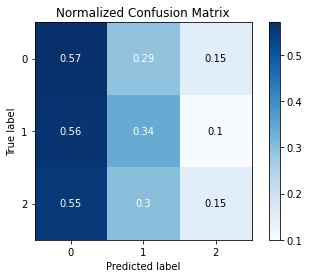

In [28]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred_MLP.argmax(axis=1), normalize=True)
plt.show()

### Word2Vec Pre-Trained Embeddings Conversion

In [29]:
!pip install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=50893067d9cb88a8041683187b80d1356c0109d354c9197247f08f3cf068c073
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
--2021-01-05 11:28:01--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.204.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.204.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.5MB/s    in 45s     

2021-01-05 11:28:47 (34.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [30]:
#Using word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

embeddings_wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
embeddings_wv.init_sims(replace=True)

In [31]:
embeddings_wv = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)  # C text format
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("euclidean_vectors.bin"), binary=True)  # C bin format

In [32]:
vocab = tokenizer.sequences_to_texts(review)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print (vocab_size)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
	try:
		embedding_vector = embeddings_ap[word]
		if embedding_vector is not None:
			embedding_matrix[i] = embedding_vector
	except:
		pass

24798


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2479800   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000100   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 3,483,198
Trainable params: 3,483,198
Non-trainable params: 0
___________________________________________________

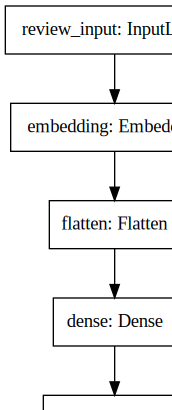

In [33]:
from keras.models import Sequential,Model
from keras.layers import Flatten,Input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

sentiment_wv_model = Sequential()
# Add embedding layer 
#No of output dimenstions is 100 as we embedded with Word2Vec 100d
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)

#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Flatten_Layer = Flatten()
review_flatten = Flatten_Layer(review_embedding)
output_size = 2

dense1 = Dense(100,activation='relu')(review_flatten)
dense2 = Dense(32,activation='relu')(dense1)
predict = Dense(2,activation='softmax')(dense2)

sentiment_wv_model = Model(inputs=[review_input],outputs=[predict])
sentiment_wv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(sentiment_wv_model.summary())
SVG(model_to_dot(sentiment_wv_model).create(prog='dot', format='svg'))

### GloVe Pre-trained Word Embeddings


In [34]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [35]:
from gensim.models import KeyedVectors

In [36]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 46429 word vectors.


In [37]:
embeddings_index['bad']

array([ 0.39456 , -0.24717 ,  1.0319  , -0.61444 , ..., -0.15905 ,  0.006497,  0.13793 , -0.06832 ], dtype=float32)

In [38]:
embed_num_dims = 100
max_seq_len = 1000

In [39]:
embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embeddings_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)

In [40]:
embedding_matrix.shape

(24798, 100)

(200, 2)


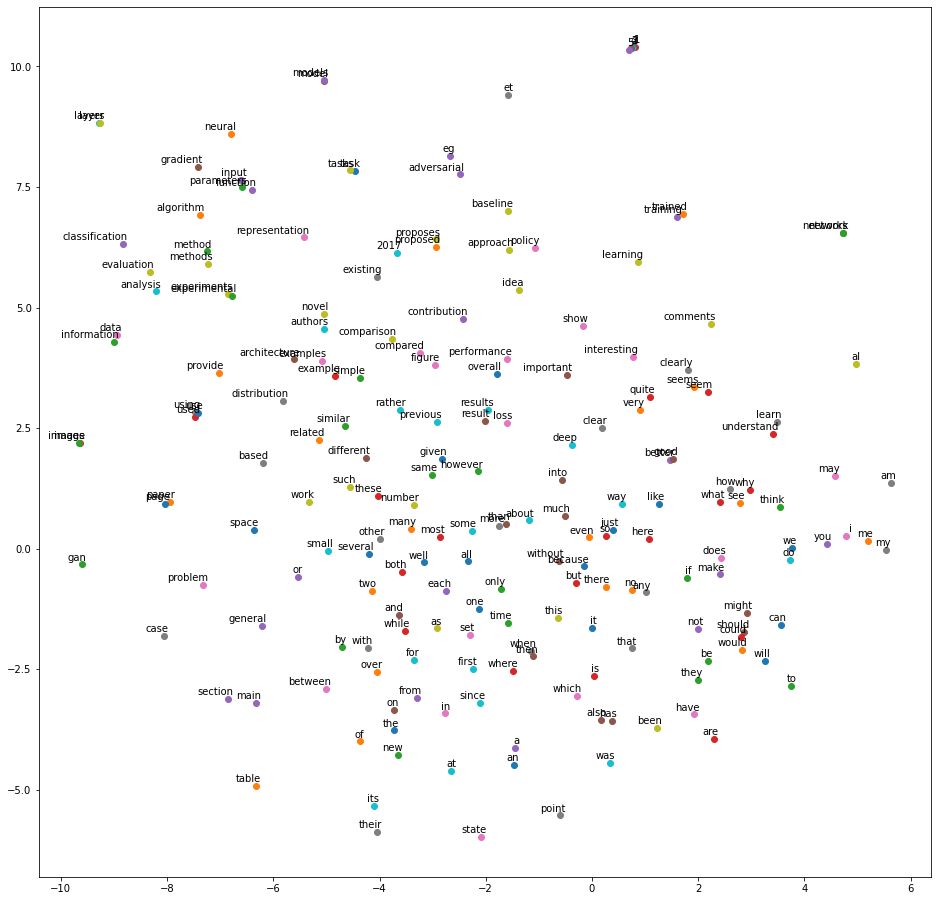

In [41]:
from sklearn.manifold import TSNE

#TSNE algorithm used to visualize word embeddings having huge amount (100) dimensions

def tsne():    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])
    print(new_values.shape)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne()

In [42]:
#Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(len(index_of_words) + 1 , embed_num_dims , input_length = max_seq_len , weights = [embedding_matrix])

In [48]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

sentiment_glove_model = Sequential()
sentiment_glove_model.add(embedd_layer)
sentiment_glove_model.add(Bidirectional(LSTM(30 , return_sequences = True , dropout = 0.1 , recurrent_dropout = 0.1)))
sentiment_glove_model.add(GlobalMaxPooling1D())
sentiment_glove_model.add(Dense(30,activation = 'relu'))
sentiment_glove_model.add(Dropout(0.2))
sentiment_glove_model.add(Dense(6,activation = 'sigmoid'))

sentiment_glove_model.summary()
add = Adam(lr = 0.01)
sentiment_glove_model.compile(loss = 'categorical_crossentropy' , optimizer = add , metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2479800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 60)          31440     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 186       
Total params: 2,513,256
Trainable params: 2,513,256
Non-trainable params: 0
____________________________________________

In [50]:
from keras.optimizers import Adam
add = Adam(lr = 0.01)
sentiment_glove_model.compile(loss = 'categorical_crossentropy' , optimizer = add , metrics = ['accuracy'])

In [51]:
sentiment_glove_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2479800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 60)          31440     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 186       
Total params: 2,513,256
Trainable params: 2,513,256
Non-trainable params: 0
____________________________________________

### Make ULMFit classification model.
#### Load ULMFit module and start tensorflow session

In [ ]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,review,sentiments
1454,\n Summary of paper\nThe paper proposes an alg...,Neutral
127,To date the theoretical advantage of deep lear...,Positive
2375,\nThe paper proposes LSDNET an active vision ...,Neutral
2216,This paper proposes another entropic regulariz...,Neutral
463,The paper presents a novel adversarial trainin...,Neutral


In [ ]:
# Text Pre-processing
# def text_cleaning(tweet):
#     letters = re.sub("[^a-zA-Z]"," ",tweet)
#     ht = re.sub(r'http\S+', '',letters)
#     mention = re.sub(r'@\w+', '', ht)
#     p = re.sub(r'[^\w\s]','',mention)
#     words = p.lower().split()
#     stops = set(stopwords.words("english"))
#     meaningful_words = [w for w in words if not w in stops]
#     return( " ".join(meaningful_words))
# data['text_clean']=data['review'].apply(lambda x: text_cleaning(x))

In [ ]:
# Y = data['sentiments']
# lenc = LabelEncoder()
# Y = lenc.fit_transform(Y)
# Y = to_categorical(Y)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data['review'], Y, test_size=0.2,random_state=37)

In [ ]:
max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()
max_words, max_len

(27200, 13460)

In [ ]:
#Tokenizer 
tk = Tokenizer(num_words=max_words)
tk.fit_on_texts(X_train)
X_train_tk = tk.texts_to_sequences(X_train)
X_test_tk = tk.texts_to_sequences(X_test)

In [ ]:
#Padding sequences
X_train_pad = sequence.pad_sequences(X_train_tk, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_tk, maxlen = max_len)

In [ ]:
num_classes = 3

In [ ]:
#Class weights Implementation for unbalanced dataset
def get_weight(y):
    class_weight_current = cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current
class_weight = get_weight(y_train.flatten())
print(class_weight)

[0.75 1.5 ]


In [ ]:
#base model
deep_lr_model = Sequential()
deep_lr_model.add(Embedding(max_words,128,input_length=max_len))
deep_lr_model.add(LSTM(128))
deep_lr_model.add(Dense(num_classes, activation='sigmoid'))
deep_lr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
deep_lr_model.summary()

In [ ]:
deep_lr_model.fit(X_train_pad, y_train, epochs=8, batch_size=32, validation_data=(X_test_pad,y_test), verbose=1)

In [ ]:
score = deep_lr_model.evaluate(X_test_pad,y_test)

16/16 [==============================] - 5s 279ms/step - loss: 2.4667 - accuracy: 0.3708


In [ ]:
print("Test Accuracy of Base Model:",score[1])

Test Accuracy of Base Model: 0.3708086907863617


In [ ]:
# data = data[['sentiments','review']]
# data.head(2)

In [ ]:
train = data[:int(len(data)*.99)]
valid = data[int(len(data)*.99):]

In [ ]:
lm_dat = TextLMDataBunch.from_df(path, train, valid)
lm_dat.save('data_lm_export.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
lm_learn = language_model_learner(lm_dat, AWD_LSTM, drop_mult=0.4)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


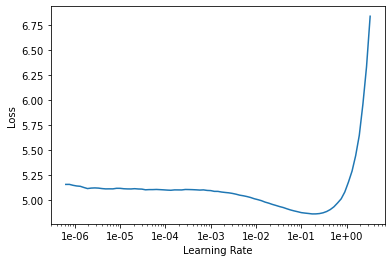

In [ ]:
lm_learn.lr_find()
lm_learn.recorder.plot()

In [ ]:
lm_learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.097306,3.981760,0.297842,00:30
1,3.796967,3.853087,0.306399,00:30
2,3.530911,3.795106,0.312946,00:30
3,3.330848,3.784266,0.313542,00:30


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


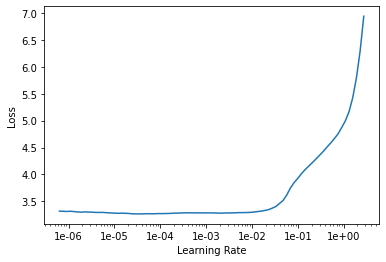

In [ ]:
lm_learn.unfreeze()
lm_learn.lr_find(); lm_learn.recorder.plot()

In [ ]:
lm_learn.fit_one_cycle(4, 1e-3)
#Encoder
lm_learn.save_encoder('ft_enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.263110,3.737539,0.319196,00:38
1,3.163275,3.702984,0.326116,00:38
2,2.940925,3.717315,0.326191,00:38
3,2.758349,3.741028,0.324851,00:38


In [ ]:
#Splitting the dataset in 80:20 ratio
train = data[:int(len(data)*.80)]
valid = data[int(len(data)*.80):]

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path, train, valid, vocab=lm_dat.train_ds.vocab, bs=32)
data_clas.save('data_clas_export.pkl'); 
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [ ]:
#Building a classifier with fine-tuned encoder 
lm_learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=.3, metrics=[accuracy,Precision(average='weighted'),Recall(average='weighted')])
lm_learn.load_encoder('ft_enc')

In [ ]:
data_clas.show_batch()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


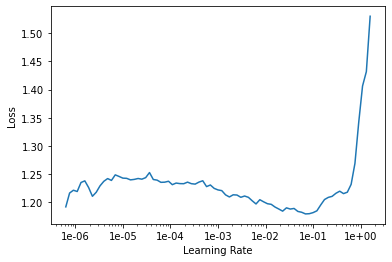

In [ ]:
lm_learn.lr_find()
lm_learn.recorder.plot()

In [ ]:
lm_learn.fit_one_cycle(4, 1e-2)

In [ ]:
lm_learn.freeze_to(-2)
lm_learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3))

In [ ]:
lm_learn.unfreeze()
lm_learn.fit_one_cycle(8, slice(1e-5/(2.6**4),1e-5))
lm_learn.save('final')

In [ ]:
#Obtaining Test Accuracy
valid['pred_sentiment'] = valid['review'].apply(lambda row: str(lm_learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(valid['sentiments'], valid['pred_sentiment']))

Test Accuracy:  0.5522682445759369


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Creation of list of reviews
review_of_paper = ["This paper presents a comprehensive framework of neural networks with a complex value. The accompanying literature identifies the various motives of neural networks with complex value: blood evidence, rich representation, simplification, rapid learning, powerful memory retrieval methods and more.",
                   "The paper proposes a neural network architecture for associative retrieval based on fast weights with context-dependent gated updates. The architecture consists of a network which provides weight updates for the network which outputs the predictions of the system. The experiments show that the architecture outperforms a couple of related models on an associative retrieval problem.",
                   "I think the main result of the paper is not surprising and does not show much beyond we can do pretraining on unlabeled datasets from a similar domain to the domain of interest."]

In [ ]:
#Creating a dataframe
data = pd.DataFrame(review_of_paper,columns=['Paper Reviews'])

In [ ]:
#Prediction of sentiment of Dataframe's reviews
data['pred_sentiment'] = data['Paper Reviews'].apply(lambda row: str(lm_learn.predict(row)[0]))
data

,Paper Reviews,pred_sentiment
0,This paper presents a comprehensive framework ...,Positive
1,The paper proposes a neural network architectu...,Positive
2,I think the main result of the paper is not su...,Negative


### Creating model RNN and LSTM

In [100]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X_tokenizer = Tokenizer(num_words=5000, split=" ")
X_tokenizer.fit_on_texts(data['review'].values)

X_tk = tokenizer.texts_to_sequences(data['review'].values)
X_tk = pad_sequences(X_tk) # padding our text vector so they all have the same length
X_tk[:5]

array([[   0,    0,    0,    0, ...,  564, 7380, 3051,  482],
       [   0,    0,    0,    0, ...,   48,    1,   32,  347],
       [   0,    0,    0,    0, ...,    5,  334,  341,  358],
       [   0,    0,    0,    0, ...,  918,    3,  338,   87],
       [   0,    0,    0,    0, ...,  625,   10,  234,  389]], dtype=int32)

In [101]:
y_tk = pd.get_dummies(data['sentiments']).values
[print(data['sentiments'][i], y_tk[i]) for i in range(0,10)]

Neutral [0 1 0]
Positive [0 0 1]
Positive [0 0 1]
Positive [0 0 1]
Negative [1 0 0]
Positive [0 0 1]
Positive [0 0 1]
Negative [1 0 0]
Neutral [0 1 0]
Positive [0 0 1]


[None, None, None, None, None, None, None, None, None, None]

In [102]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

sentiment_rnn_lstm_model = Sequential()
sentiment_rnn_lstm_model.add(Embedding(5000, 256, input_length=X_tk.shape[1]))
sentiment_rnn_lstm_model.add(layers.SimpleRNN(128,activation='relu',return_sequences=True))
sentiment_rnn_lstm_model.add(Dropout(0.3))
sentiment_rnn_lstm_model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
sentiment_rnn_lstm_model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
sentiment_rnn_lstm_model.add(Dense(3, activation='softmax'))
sentiment_rnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sentiment_rnn_lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 2545, 256)         1280000   
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 2545, 128)         49280     
_________________________________________________________________
dropout_10 (Dropout)         (None, 2545, 128)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 2545, 256)         394240    
_________________________________________________________________
lstm_18 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 771       
Total params: 2,249,603
Trainable params: 2,249,603
Non-trainable params: 0
___________________________________________

In [103]:
Xtk_train, Xtk_test, ytk_train, ytk_test = train_test_split(X_tk, y_tk, test_size=0.2, random_state=0)

### Training RNN and LSTM model


In [ ]:
batch_size = 32
epochs = 8
sentiment_rnn_lstm_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)

In [ ]:
sentiment_rnn_lstm_model.save('sentiment_rnn_lstm_model.h5')
print(sentiment_rnn_lstm_model)

In [ ]:
sentiment_rnn_lstm_model.load('/content/sentiment_rnn_lstm_model.h5')
print(sentiment_rnn_lstm_model)

In [ ]:
predictions = sentiment_rnn_lstm_model.predict(X_test)

[print(data['review'][i], predictions[i], y_test[i]) for i in range(0, 2)]

In [ ]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 139
Neutral predictions: 220
Negative predictions: 148
Real positive: 130
Real neutral: 201
Real negative: 176
